In [1]:
# Impoting required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# setting default option
pd.set_option("mode.copy_on_write", True)

In [2]:
# importing datasets
df = pd.read_parquet("../.01_Data/02_Processed/02_Mortality.parquet")
df.sample(5)

State State_Code       County County_Code  Year  \
5627  South Carolina         SC  SPARTANBURG       45083  2010   
2482  South Carolina         SC     RICHLAND       45079  2006   
4771    Pennsylvania         PA    LANCASTER       42071  2009   
1132           Texas         TX       ORANGE       48361  2004   
3524         Florida         FL         LEON       12073  2008   

                                                  Cause  Deaths  
5627  Drug poisonings (overdose) Unintentional (X40-...      46  
2482                      All other drug-induced causes      10  
4771  Drug poisonings (overdose) Unintentional (X40-...      42  
1132  Drug poisonings (overdose) Unintentional (X40-...      18  
3524  Drug poisonings (overdose) Unintentional (X40-...      14

In [3]:
population = pd.read_parquet("../.01_Data/02_Processed/01_Population.parquet")
population.sample(5)

State State_Code  County County_Code  Year  Population
25528  North Dakota         ND  BENSON       38005  2012        6771
27651      Oklahoma         OK   GRADY       40051  2003       47277
8696        Indiana         IN   ADAMS       18001  2015       34962
11483        Kansas         KS     ELK       20049  2007        2939
3378       Colorado         CO  MORGAN       08087  2014       28098

In [4]:
# Dropping Alaska
df = df[df["State_Code"] != "AK"]

In [5]:
# Viewing distribution of drug related deaths
df["Cause"].value_counts()

Cause
Drug poisonings (overdose) Unintentional (X40-X44)    7538
Drug poisonings (overdose) Suicide (X60-X64)          1461
Drug poisonings (overdose) Undetermined (Y10-Y14)      757
All other drug-induced causes                          625
Drug poisonings (overdose) Homicide (X85)                2
Name: count, dtype: int64

In [6]:
# We will consider only unintentional drug related deaths since other have very few values
df = df[df["Cause"] == "Drug poisonings (overdose) Unintentional (X40-X44)"]

In [7]:
# checking for missing values
df.isnull().sum()

State          0
State_Code     0
County         0
County_Code    0
Year           0
Cause          0
Deaths         2
dtype: int64

In [8]:
df[df["Deaths"].isna()]

State State_Code              County County_Code  Year  \
10345  Virginia         VA        BEDFORD CITY       51515  2015   
10351  Virginia         VA  CLIFTON FORGE CITY       51560  2015   

                                                   Cause  Deaths  
10345  Drug poisonings (overdose) Unintentional (X40-...    <NA>  
10351  Drug poisonings (overdose) Unintentional (X40-...    <NA>

In [9]:
# drop these NAs for now since they are all in VA and in 2015
df = df.dropna()

In [10]:
df["Deaths"].describe()

count       7536.0
mean     42.073248
std      59.844214
min           10.0
25%           13.0
50%           21.0
75%           43.0
max          705.0
Name: Deaths, dtype: Float64

In [11]:
population["Population"].describe()

count    4.049500e+04
mean     9.803144e+04
std      3.135551e+05
min      0.000000e+00
25%      1.126200e+04
50%      2.577600e+04
75%      6.644000e+04
max      1.007726e+07
Name: Population, dtype: float64

In [12]:
# Merging the datasets

combined = pd.merge(
    df,
    population,
    on=["State", "State_Code", "County", "County_Code", "Year"],
    how="left",
    validate="1:1",
    indicator=True,
)
combined.sample(5)

State State_Code           County County_Code  Year  \
2870   California         CA             LAKE       06033  2009   
757      Virginia         VA  PORTSMOUTH CITY       51740  2004   
2524  Mississippi         MS          HANCOCK       28045  2008   
126      Kentucky         KY        JEFFERSON       21111  2003   
4976     Michigan         MI        KALAMAZOO       26077  2012   

                                                  Cause  Deaths  Population  \
2870  Drug poisonings (overdose) Unintentional (X40-...      21       64413   
757   Drug poisonings (overdose) Unintentional (X40-...      16       97428   
2524  Drug poisonings (overdose) Unintentional (X40-...      10       42764   
126   Drug poisonings (overdose) Unintentional (X40-...      72      703970   
4976  Drug poisonings (overdose) Unintentional (X40-...      19      255413   

     _merge  
2870   both  
757    both  
2524   both  
126    both  
4976   both

In [13]:
# Checking for merge errors
combined["_merge"].value_counts()

_merge
both          7536
left_only        0
right_only       0
Name: count, dtype: int64

In [14]:
# Check if all rows have non-0 population so that we don't divide by 0
combined["Population"].describe()

count    7.536000e+03
mean     3.861557e+05
std      6.451696e+05
min      1.028200e+04
25%      1.042135e+05
50%      1.955340e+05
75%      4.350700e+05
max      1.007726e+07
Name: Population, dtype: float64

In [15]:
# Checking for Deaths, should be all non-0 and min 10
combined["Deaths"].describe()

count       7536.0
mean     42.073248
std      59.844214
min           10.0
25%           13.0
50%           21.0
75%           43.0
max          705.0
Name: Deaths, dtype: Float64

In [16]:
# creating new df with only required columns
df2 = combined[
    ["State", "State_Code", "County", "County_Code", "Year", "Population", "Deaths"]
]

In [17]:
# calculating mortality rate
df3 = df2.copy()
df3["Mortality_Rate"] = df3["Deaths"] / df3["Population"]
df3.sample(5)

State State_Code             County County_Code  Year  Population  \
5539     Indiana         IN           HAMILTON       18057  2013      296970   
755     Virginia         VA  NEWPORT NEWS CITY       51700  2004      185204   
6822  California         CA    SAN LUIS OBISPO       06079  2015      280138   
5027  New Jersey         NJ         BURLINGTON       34005  2012      450667   
1518    New York         NY           ROCKLAND       36087  2006      299390   

      Deaths  Mortality_Rate  
5539      15        0.000051  
755       16        0.000086  
6822      43        0.000153  
5027      69        0.000153  
1518      10        0.000033

In [18]:
# Calculating  mortality rate for each state-year
df4 = (
    df3.groupby(["State", "Year"])
    .agg({"Population": "sum", "Deaths": "sum"})
    .reset_index()
)
df4.sample(5)

State  Year  Population  Deaths
597   Wisconsin  2011     3075370     412
33     Arkansas  2011     1434425     135
38   California  2003    33561483    2316
79     Delaware  2005      523343      37
9       Alabama  2012     2858447     352

In [19]:
# check if we have data for all years in all states
df4[["State", "Year"]]["State"].value_counts()

State
Alabama                 13
Wisconsin               13
Missouri                13
Arizona                 13
Nevada                  13
New Hampshire           13
New Jersey              13
New Mexico              13
New York                13
North Carolina          13
Ohio                    13
Virginia                13
Oklahoma                13
Oregon                  13
Pennsylvania            13
South Carolina          13
West Virginia           13
Tennessee               13
Texas                   13
Utah                    13
Mississippi             13
Minnesota               13
Michigan                13
Massachusetts           13
California              13
Colorado                13
Connecticut             13
Delaware                13
District of Columbia    13
Florida                 13
Georgia                 13
Hawaii                  13
Idaho                   13
Illinois                13
Indiana                 13
Iowa                    13
Kansas                

In [20]:
# check if we have data for all years in all states
df4[["State", "Year"]]["State"].value_counts().value_counts()

count
13    41
12     3
7      2
11     1
10     1
4      1
1      1
Name: count, dtype: int64

Some states have data for very few years, so be cautious when using the data for these states

In [21]:
# Calculating Mortality Rate at state level
df4["State_Mortality_Rate"] = df4["Deaths"] / df4["Population"]

In [22]:
# combinations of state and county from population data
st_county = population[
    ["State", "State_Code", "County", "County_Code", "Year"]
].drop_duplicates()
st_county.sample(5)

State State_Code     County County_Code  Year
33173       Texas         TX     DAWSON       48115  2013
20776     Montana         MT    MEAGHER       30059  2005
32909       Texas         TX  CHILDRESS       48075  2009
33829       Texas         TX       HILL       48217  2006
23359  New Mexico         NM   TORRANCE       35057  2014

In [23]:
# Creating a cross-join at state and county level
master = pd.merge(st_county, df4, on=["State", "Year"], how="left", indicator=True)
master.sample(5)

State State_Code       County County_Code  Year  Population  \
7032          Idaho         ID       CUSTER       16037  2015    775025.0   
2928       Colorado         CO  CLEAR CREEK       08019  2006   3570120.0   
21150      Nebraska         NE     ANTELOPE       31003  2015    855606.0   
30353  South Dakota         SD       BEADLE       46005  2014    180925.0   
30737  South Dakota         SD       HUGHES       46065  2008         NaN   

       Deaths  State_Mortality_Rate     _merge  
7032       87              0.000112       both  
2928      366              0.000103       both  
21150      59              0.000069       both  
30353      14              0.000077       both  
30737    <NA>                  <NA>  left_only

In [24]:
master["_merge"].value_counts()

_merge
both          38673
left_only      1822
right_only        0
Name: count, dtype: int64

These 1822 combinations are not present in our actual data and hence will have to be imputed

In [25]:
master[master["_merge"] == "left_only"]

State State_Code    County County_Code  Year  Population  Deaths  \
1066   Arkansas         AR  ARKANSAS       05001  2003         NaN    <NA>   
1079   Arkansas         AR    ASHLEY       05003  2003         NaN    <NA>   
1092   Arkansas         AR    BAXTER       05005  2003         NaN    <NA>   
1105   Arkansas         AR    BENTON       05007  2003         NaN    <NA>   
1118   Arkansas         AR     BOONE       05009  2003         NaN    <NA>   
...         ...        ...       ...         ...   ...         ...     ...   
40483   Wyoming         WY    WESTON       56045  2004         NaN    <NA>   
40484   Wyoming         WY    WESTON       56045  2005         NaN    <NA>   
40485   Wyoming         WY    WESTON       56045  2006         NaN    <NA>   
40487   Wyoming         WY    WESTON       56045  2008         NaN    <NA>   
40490   Wyoming         WY    WESTON       56045  2011         NaN    <NA>   

       State_Mortality_Rate     _merge  
1066                   <NA>  left_only  
1079                   <NA>  left_only  
1092                   <NA>  left_only  
1105                   <NA>  left_only  
1118                   <NA>  left_only  
...                     ...        ...  
40483                  <NA>  left_only  
40484                  <NA>  left_only  
40485                  <NA>  left_only  
40487                  <NA>  left_only  
40490                  <NA>  left_only  

[1822 rows x 9 columns]

In [26]:
master[master["_merge"] == "left_only"][["State", "Year"]].drop_duplicates()

State  Year
1066       Arkansas  2003
15136      Maryland  2007
20398       Montana  2004
20400       Montana  2006
20405       Montana  2011
21125      Nebraska  2003
25493  North Dakota  2003
25494  North Dakota  2004
25495  North Dakota  2005
25496  North Dakota  2006
25497  North Dakota  2007
25498  North Dakota  2008
25499  North Dakota  2009
25500  North Dakota  2010
25501  North Dakota  2011
25502  North Dakota  2012
25503  North Dakota  2013
25505  North Dakota  2015
29666  Rhode Island  2003
29667  Rhode Island  2004
30329  South Dakota  2003
30330  South Dakota  2004
30331  South Dakota  2005
30332  South Dakota  2006
30333  South Dakota  2007
30334  South Dakota  2008
30336  South Dakota  2010
30337  South Dakota  2011
30338  South Dakota  2012
36101       Vermont  2003
36102       Vermont  2004
36103       Vermont  2005
36106       Vermont  2008
36107       Vermont  2009
36108       Vermont  2010
40196       Wyoming  2003
40197       Wyoming  2004
40198       Wyoming  2005
40199       Wyoming  2006
40201       Wyoming  2008
40204       Wyoming  2011

We have to drop these states since we don't have any data for them even at a state level so would not make sense to impute for them

In [27]:
# dropping these rows since we have no state level data for them
master = master[master["_merge"] == "both"]

In [28]:
master["State_Mortality_Rate"].describe()

count     38673.0
mean     0.000114
std      0.000054
min      0.000012
25%       0.00008
50%      0.000101
75%      0.000134
max      0.000465
Name: State_Mortality_Rate, dtype: Float64

In [29]:
# create a new df with only required columns
master2 = master[
    ["State", "State_Code", "County", "County_Code", "Year", "State_Mortality_Rate"]
]

In [30]:
# merging this with the original Data
df5 = pd.merge(
    master2,
    df3,
    on=["State", "State_Code", "County", "County_Code", "Year"],
    how="left",
    indicator=True,
    validate="1:1",
)
df5.sample(5)

State State_Code    County County_Code  Year  \
2680   California         CA  TUOLUMNE       06109  2015   
38133   Wisconsin         WI    OCONTO       55083  2014   
31548       Texas         TX    DALLAM       48111  2014   
21399    Nebraska         NE    HOOKER       31091  2005   
32383       Texas         TX    JASPER       48241  2004   

       State_Mortality_Rate  Population  Deaths  Mortality_Rate     _merge  
2680               0.000103     53599.0      19        0.000354       both  
38133              0.000157         NaN    <NA>            <NA>  left_only  
31548              0.000084         NaN    <NA>            <NA>  left_only  
21399              0.000031         NaN    <NA>            <NA>  left_only  
32383              0.000066         NaN    <NA>            <NA>  left_only

In [31]:
df5["_merge"].value_counts()

_merge
left_only     31137
both           7536
right_only        0
Name: count, dtype: int64

In [32]:
# adding a new flag to identify if original data or not
df5["Original"] = df5["_merge"] == "both"

In [33]:
df5.sample(5)

State State_Code    County County_Code  Year  \
20757        Montana         MT  SHERIDAN       30091  2015   
16066       Michigan         MI  KEWEENAW       26083  2009   
33364          Texas         TX   REFUGIO       48391  2010   
37500  West Virginia         WV     WAYNE       54099  2005   
12151         Kansas         KS     ROOKS       20163  2009   

       State_Mortality_Rate  Population  Deaths  Mortality_Rate     _merge  \
20757                0.0001         NaN    <NA>            <NA>  left_only   
16066              0.000113         NaN    <NA>            <NA>  left_only   
33364              0.000081         NaN    <NA>            <NA>  left_only   
37500              0.000111         NaN    <NA>            <NA>  left_only   
12151              0.000083         NaN    <NA>            <NA>  left_only   

       Original  
20757     False  
16066     False  
33364     False  
37500     False  
12151     False

In [34]:
df5[["_merge", "Original"]].value_counts()

_merge     Original
left_only  False       31137
both       True         7536
Name: count, dtype: int64

In [35]:
# Remapping with population data
df6 = pd.merge(
    df5,
    population[["County_Code", "Year", "Population"]],
    on=["County_Code", "Year"],
    how="left",
    indicator="merge2",
    validate="1:1",
)
df6.sample(5)

State State_Code       County County_Code  Year  \
29268  South Carolina         SC  SPARTANBURG       45083  2013   
5670          Georgia         GA        JONES       13169  2015   
13463        Kentucky         KY       MARION       21155  2008   
6463          Georgia         GA        UPSON       13293  2015   
31212           Texas         TX      CAMERON       48061  2003   

       State_Mortality_Rate  Population_x  Deaths  Mortality_Rate     _merge  \
29268              0.000125      290545.0      35         0.00012       both   
5670               0.000122           NaN    <NA>            <NA>  left_only   
13463              0.000193           NaN    <NA>            <NA>  left_only   
6463               0.000122           NaN    <NA>            <NA>  left_only   
31212              0.000068           NaN    <NA>            <NA>  left_only   

       Original  Population_y merge2  
29268      True        290545   both  
5670      False         28432   both  
13463     False         19647   both  
6463      False         26237   both  
31212     False        358492   both

In [36]:
df6["merge2"].value_counts()

merge2
both          38673
left_only         0
right_only        0
Name: count, dtype: int64

In [37]:
# check if we have population data for all counties
df6["Population_y"].describe()

count    3.867300e+04
mean     1.016857e+05
std      3.201735e+05
min      0.000000e+00
25%      1.229900e+04
50%      2.715300e+04
75%      6.946000e+04
max      1.007726e+07
Name: Population_y, dtype: float64

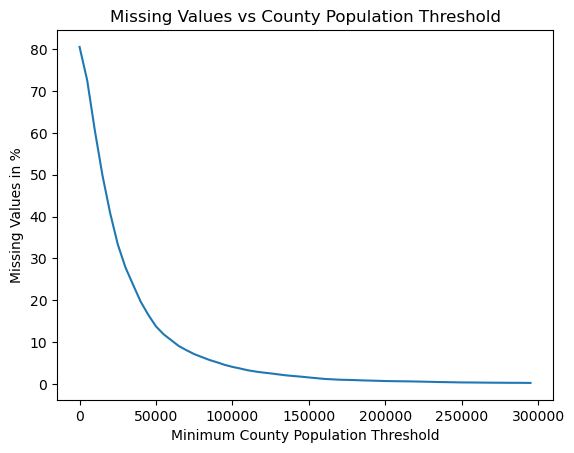

In [38]:
# graph to check missing in original vs population
threshold = []
missing = []
for i in range(0, 300000, 5000):
    threshold.append(i)
    missing.append(
        (df6[df6["Population_y"] >= i]["Mortality_Rate"].isna().sum()) / len(df6) * 100
    )

# plotting this
plt.plot(threshold, missing)
plt.xlabel("Minimum County Population Threshold")
plt.ylabel("Missing Values in %")
plt.title("Missing Values vs County Population Threshold")

# Saving the plot
plt.savefig("../.01_Data/Missing_vs_Population.png")
plt.show()

The lower population counties will add a lot of noise to the data, hence it is important to consider this when we plan to use the imputed data for any analysis.

In [39]:
# function to Impute the deaths
def new_death(row):
    if pd.isna(row["Deaths"]):
        # calculate based on state mortality rate, with upper theshold of 9
        return min(int(row["Population_y"] * row["State_Mortality_Rate"]), 9)
    else:
        # has original data so return the original value
        return row["Deaths"]

In [40]:
df7 = df6.copy()
df7["Deaths_2"] = df7.apply(new_death, axis=1)
df7.sample(5)

State State_Code        County County_Code  Year  \
17930   Mississippi         MS        COPIAH       28029  2014   
12320        Kansas         KS       STEVENS       20189  2009   
3895        Florida         FL         DUVAL       12031  2008   
14815     Louisiana         LA  WEST CARROLL       22123  2008   
28304  Pennsylvania         PA        LEHIGH       42077  2014   

       State_Mortality_Rate  Population_x  Deaths  Mortality_Rate     _merge  \
17930               0.00015           NaN    <NA>            <NA>  left_only   
12320              0.000083           NaN    <NA>            <NA>  left_only   
3895               0.000135      855437.0      89        0.000104       both   
14815              0.000145           NaN    <NA>            <NA>  left_only   
28304              0.000197      357591.0      55        0.000154       both   

       Original  Population_y merge2  Deaths_2  
17930     False         28976   both         4  
12320     False          5592   both         0  
3895       True        855437   both        89  
14815     False         11670   both         1  
28304      True        357591   both        55

In [41]:
# Creating a new df with only required columns
df8 = df7[
    [
        "State",
        "State_Code",
        "County",
        "County_Code",
        "Year",
        "Population_y",
        "Deaths_2",
        "Original",
        "State_Mortality_Rate",
    ]
]

# Renaming columns
df8 = df8.rename(columns={"Population_y": "Population", "Deaths_2": "Deaths"})

df8.sample(5)

State State_Code     County County_Code  Year  Population  \
2566       California         CA   SISKIYOU       06093  2005       44641   
6476          Georgia         GA     WALKER       13295  2015       68604   
20797         Montana         MT      TETON       30099  2015        6064   
21154        Nebraska         NE      DEUEL       31049  2012        1958   
24414  North Carolina         NC  HENDERSON       37089  2012      107811   

       Deaths  Original  State_Mortality_Rate  
2566        3     False              0.000071  
6476        8     False              0.000122  
20797       0     False                0.0001  
21154       0     False              0.000091  
24414      12      True              0.000108

In [42]:
# Calculating Mortality Rate for each county, if population is 0 then mortality rate is 0
df8["County_Mortality_Rate"] = np.where(
    df8["Population"] == 0, 0, df8["Deaths"] / df8["Population"]
)
df8.sample(5)

State State_Code     County County_Code  Year  Population  Deaths  \
4773     Georgia         GA      BRYAN       13029  2015       34860       4   
9653     Indiana         IN      UNION       18161  2007        7467       0   
7188       Idaho         ID     OWYHEE       16073  2012       11411       0   
13180   Kentucky         KY  JEFFERSON       21111  2011      746458     129   
17294  Minnesota         MN     NOBLES       27105  2015       21754       2   

       Original  State_Mortality_Rate  County_Mortality_Rate  
4773      False              0.000122               0.000115  
9653      False              0.000085               0.000000  
7188      False              0.000084               0.000000  
13180      True              0.000258               0.000173  
17294     False              0.000099               0.000092

In [43]:
# sorting the rows
df9 = df8.sort_values(by=["State", "County", "Year"]).reset_index(drop=True)
df9.sample(5)

State State_Code        County County_Code  Year  Population  \
23379   New York         NY        MONROE       36055  2004      741075   
33474      Texas         TX  SAN PATRICIO       48409  2003       66440   
5794     Georgia         GA         MACON       13193  2009       14842   
30023  Tennessee         TN       HANCOCK       47067  2010        6796   
32951      Texas         TX        MENARD       48327  2013        2138   

       Deaths  Original  State_Mortality_Rate  County_Mortality_Rate  
23379       9     False              0.000058               0.000012  
33474       4     False              0.000068               0.000060  
5794        1     False              0.000087               0.000067  
30023       0     False              0.000147               0.000000  
32951       0     False               0.00008               0.000000

In [44]:
df9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38673 entries, 0 to 38672
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   State                  38673 non-null  object 
 1   State_Code             38673 non-null  object 
 2   County                 38673 non-null  object 
 3   County_Code            38673 non-null  object 
 4   Year                   38673 non-null  int64  
 5   Population             38673 non-null  int64  
 6   Deaths                 38673 non-null  int64  
 7   Original               38673 non-null  bool   
 8   State_Mortality_Rate   38673 non-null  Float64
 9   County_Mortality_Rate  38673 non-null  float64
dtypes: Float64(1), bool(1), float64(1), int64(3), object(4)
memory usage: 2.7+ MB


In [45]:
df9.describe()

Year    Population        Deaths  State_Mortality_Rate  \
count  38673.000000  3.867300e+04  38673.000000               38673.0   
mean    2009.085408  1.016857e+05     10.279446              0.000114   
std        3.735477  3.201735e+05     30.797244              0.000054   
min     2003.000000  0.000000e+00      0.000000              0.000012   
25%     2006.000000  1.229900e+04      1.000000               0.00008   
50%     2009.000000  2.715300e+04      2.000000              0.000101   
75%     2012.000000  6.946000e+04      9.000000              0.000134   
max     2015.000000  1.007726e+07    705.000000              0.000465   

       County_Mortality_Rate  
count           38673.000000  
mean                0.000087  
std                 0.000079  
min                 0.000000  
25%                 0.000043  
50%                 0.000079  
75%                 0.000119  
max                 0.001266